<a href="https://colab.research.google.com/github/ssandanshi/Super-Resolution-GAN/blob/master/Neural_Network_F2_SRGAN_SSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import pickle
import time

#Data Generator
import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE

#Model/Trainer
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.keras.models import Model

#Predict
from google.colab import files
from PIL import Image
import shutil


# Data Generator

In [0]:

def dataset(subset='train',images_dir='data/images',caches_dir='data/cache',batch_size=16, repeat_times=None, random_transform=True):
    if subset == 'train':
        image_list = range(1, 801)
    elif subset == 'valid':
        image_list = range(801, 901)
    else:
        raise Exception('Invalid subset name')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(caches_dir, exist_ok=True)
    hr_dir = images_dir+"/"+'DIV2K_'+subset+'_HR'
    lr_dir = images_dir+"/"+'DIV2K_'+subset+'_LR_unknown/X4'

    lr_ds = get_data(subset,lr_dir,"LR",image_list,caches_dir)
    hr_ds = get_data(subset,hr_dir,"HR",image_list,caches_dir)
    #print(type(lr_ds),type(hr_ds),lr_ds)
    ds = tf.data.Dataset.zip((lr_ds, hr_ds))
    if random_transform:
        ds = ds.map(lambda lr, hr: generate_cropped_image(lr, hr), num_parallel_calls=AUTOTUNE)
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.repeat(repeat_times)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [0]:
def get_data(subset,directory,res,image_list,caches_dir):
    if res == "HR":
        cache_file = os.path.join(caches_dir, f'DIV2K_{subset}_HR.cache')
        cache_index = f'{cache_file}.index'
        archive_file = 'DIV2K_'+subset+'_HR.zip'
        image_dir_list = [os.path.join(directory, f'{image_id:04}.png') for image_id in image_list]
    else:
        cache_file = os.path.join(caches_dir, f'DIV2K_{subset}_LR_unknown_X4.cache')
        cache_index = f'{cache_file}.index'
        archive_file = 'DIV2K_'+subset+'_LR_unknown_X4.zip'
        image_dir_list = [os.path.join(directory, f'{image_id:04}x4.png') for image_id in image_list]

    if not os.path.exists(directory):
        download_data(archive_file, 'data/images')
    
    ds = tf.data.Dataset.from_tensor_slices(image_dir_list)
    ds = ds.map(tf.io.read_file)
    ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
    ds = ds.cache(cache_file)

    if not os.path.exists(cache_index):
        populate_cache(ds, cache_file)
    
    return ds

In [0]:
def populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')

def download_data(file, target_dir):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    print(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=True)
    os.remove(os.path.join(target_dir, file))    

### Data Augmentation

In [0]:
def generate_cropped_image(lr_img, hr_img, crop_hr_dim=96):
    crop_lr_dim = int(crop_hr_dim/4)
    lr_img_shape = tf.shape(lr_img)[:2]

    #Generate random numbers in x and y to start the crop
    rand_x = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - crop_lr_dim + 1, dtype=tf.int32)
    rand_y = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - crop_lr_dim + 1, dtype=tf.int32)

    #Corresponding cell in high resolution
    hr_x = rand_x * 4
    hr_y = rand_y * 4

    cropped_lr = lr_img[rand_y:rand_y + crop_lr_dim, rand_x:rand_x + crop_lr_dim]
    cropped_hr = hr_img[hr_y:hr_y + crop_hr_dim, hr_x:hr_x + crop_hr_dim]

    return cropped_lr, cropped_hr

#Mirror image horizontally randomly
def random_flip(lr_img, hr_img):
    #Generate a random number
    rn = tf.random.uniform(shape=(), maxval=1)
    #If random number more than 0.5, flip
    return tf.cond(rn < 0.5,
                    lambda: (lr_img, hr_img),
                    lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

#Generate a random number from 0 and 4. Rotate the image that many times counter clockwise
def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

In [0]:
train_ds = dataset(subset="train",repeat_times=None,random_transform=True)

In [0]:
valid_ds = dataset(subset="valid",repeat_times=None,random_transform=True)

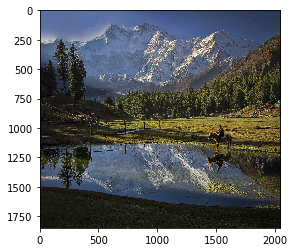

In [0]:
plt.imshow(cv2.imread('data/images/DIV2K_train_HR/0002.png')[...,::-1])

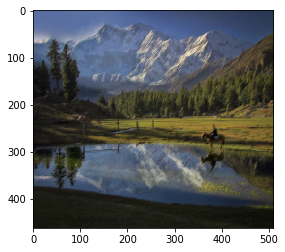

In [0]:
plt.imshow(cv2.imread('data/images/DIV2K_train_LR_unknown/X4/0002x4.png')[...,::-1])

# Evaluation (PSNR)

In [0]:
#Mean of all High Resolution Images for normalization
#source: https://github.com/limbee/NTIRE2017/blob/master/code/tools/stat_DIV2K.lua#L9
HR_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

In [0]:
#super resolution round batch
def super_resolution(model, low_res_batch):
    low_res_batch = tf.cast(low_res_batch, tf.float32)
    #run model to get super resolution images for given low res images
    super_res_batch = model(low_res_batch)
    super_res_batch = tf.clip_by_value(super_res_batch, 0, 255) #make sure within range (0,255)
    super_res_batch = tf.round(super_res_batch)
    super_res_batch = tf.cast(super_res_batch, tf.uint8)
    return super_res_batch

#Find Mean of PSNR on given dataset
def evaluate_psnr(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = super_resolution(model, lr)
        psnr_value = (psnr)(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)

#Find Mean of SSIM on given dataset
def evaluate_ssim(model, dataset):
    ssim_values = []
    for lr, hr in dataset:
        sr = super_resolution(model, lr)
        ssim_value = (ssim)(hr, sr)[0]
        ssim_values.append(ssim_value)
    return tf.reduce_mean(ssim_values)

## Normalizing Input

In [0]:
def normalize_cnn(x):
  return (x - HR_RGB_MEAN) / 127.5 #Standardize

def normalize_gan_gen(x):
  return x / 255.0 #Normalizes RGB images to [0, 1]

def normalize_gan_dis(x):
  return x / 127.5 - 1 #Normalizes RGB images to [-1, 1].

def denormalize(x):
  return x * 127.5 + HR_RGB_MEAN
      
def denormalize_gan_gen(x):
  return (x + 1) * 127.5

## Find PSNR

In [0]:
#Evaluate PSNR for 2 images
def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

def ssim(x1, x2):
    return tf.image.ssim(x1, x2, max_val=255)

def psnr2(groundtruth,pred):
  #return -10. * np.log10(np.mean(np.square(pred - groundtruth)))
  #return tf.image.psnr(groundtruth, pred, max_val=255)
  max_pixel = 1.0
  return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(pred - groundtruth), axis=-1)))) / 2.303

In [0]:
#Used for upsampling image
#source: https://github.com/twairball/keras-subpixel-conv
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)


    return Lambda(subpixel, output_shape=subpixel_shape)

# Model

In [0]:
#Residual Block for ResCNN
def residual_block(x_in, num_filters,kernel_size):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_in, x])
    return x

In [0]:
#Generator for GAN = ResCNN
def generator(input_shape=(None,None,3),num_filters=64, num_res_blocks=16, kernel_size=3):
    x = x_in = Input(shape=input_shape)
    x = Lambda(normalize_gan_gen)(x_in) 

    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = x_1 = Activation('relu')(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters,kernel_size=kernel_size)

    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    #upsample
    x = Conv2D(256, 3, padding='same')(x)
    x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
    x = Activation('relu')(x)

    x = Conv2D(256, 3, padding='same')(x)
    x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
    x = Activation('relu')(x)

    x = Conv2D(3, kernel_size=1, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_gan_gen)(x)
    return Model(x_in, x, name='generator')


In [0]:
#GAN - Discriminator Block
def discriminator_block(x,num_filters=64,kernel_size=3,strides=1,activation='relu',batchnorm=True):
  x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  if batchnorm:
      x = BatchNormalization()(x)
  if activation == "lrelu":
    x = LeakyReLU(alpha=0.2)(x)
  elif activation == 'relu':
    x = Activation('relu')(x)
  return x

In [0]:
#GAN - Discriminator
def discriminator(input_shape=(96,96,3),num_filters=64):
  x = x_in = Input(shape=input_shape)
  x = Lambda(normalize_gan_dis)(x_in)

  x = discriminator_block(x,num_filters=num_filters,kernel_size=4,strides=2,activation='lrelu',batchnorm=False)
  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*4,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*8,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*16,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*32,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*16,kernel_size=1,strides=1,activation='lrelu',batchnorm=True)
  x_1 = x = discriminator_block(x,num_filters=num_filters*8,kernel_size=1,strides=1,activation=None,batchnorm=True)

  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=1,strides=1,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=3,strides=1,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*8,kernel_size=3,strides=1,activation=None,batchnorm=True)

  x = Add()([x_1, x])
  x = LeakyReLU(alpha=0.2)(x)
  x = Flatten()(x)

  #Hidden FNN Layer
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Dense(1, activation='sigmoid')(x)

  return Model(x_in, x, name='discriminator')


In [0]:
def get_vgg_model_layer(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

In [0]:
gan_generator = generator()
gan_generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, None, None, 6 1792        lambda_5[0][0]                   
__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 6 0           conv2d_48[0][0]                  
__________________________________________________________________________________________

In [0]:
gan_discriminator = discriminator()
gan_discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 96, 96, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 48, 48, 64)   3136        lambda_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 48, 48, 64)   0           conv2d_85[0][0]                  
______________________________________________________________________________________

# Pre Training Generator

In [0]:
from collections import defaultdict
import pickle

In [0]:
class PreTrainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/gan_pre'):

        self.now = None
        self.loss = loss
        self.history = defaultdict(list)
        self.checkpoint = tf.train.Checkpoint(optimizer=Adam(learning_rate),
                                              psnr=tf.Variable(-1.0),
                                              ssim=tf.Variable(-1.0),
                                              step=tf.Variable(0),
                                              model=model)
        self.model = self.checkpoint.model
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             max_to_keep=3,
                                                             directory=checkpoint_dir)

        self.restore()

    def train(self, train_ds, valid_ds, steps, eval_when=1000, save_best=False):
        loss_mean = Mean()
        self.now = time.perf_counter()

        for lr, hr in train_ds.take(steps - self.checkpoint.step.numpy()):
            self.checkpoint.step.assign_add(1)
            step = self.checkpoint.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            #Evaluate PSNR
            if step % eval_when == 0:
                loss_value = loss_mean.result()
                self.history['loss'].append(loss_value)
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = evaluate_psnr(self.checkpoint.model,valid_ds)
                # Compute SSIM on validation dataset
                ssim_value = evaluate_ssim(self.checkpoint.model,valid_ds)
                self.history['psnr'].append(psnr_value)
                self.history['ssim'].append(ssim_value)

                duration = time.perf_counter() - self.now
                print('Step Num:',str(step),'out of',str(steps),'Loss:',str(round(loss_value.numpy(),3)),'PSNR:',str(round(psnr_value.numpy(),3)),'SSIM:',str(round(ssim_value.numpy(),3)),'Time Taken:',str(round(duration,2)))

                # skip saving checkpoint, no PSNR improvement
                if save_best and psnr_value <= self.checkpoint.psnr:
                    self.now = time.perf_counter()
                    continue

                self.checkpoint.psnr = psnr_value
                self.checkpoint.ssim = ssim_value
                self.checkpoint_manager.save()
                self.now = time.perf_counter()
            #Save checkpoints to drive
            if step % 5000:
              try:
                shutil.rmtree('gdrive/My Drive/SR/GAN/ckpt')
                shutil.copytree('ckpt','gdrive/My Drive/SR/GAN/ckpt')
                pickle.dump(self.history,open('pre-history.pkl','wb'))
                shutil.copyfile('pre-history.pkl','gdrive/My Drive/SR/GAN/pre-history.pkl')
              except:
                pass
              


    #Update Weights - Apply Gradient Descent
    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            sr = self.checkpoint.model(tf.cast(lr, tf.float32), training=True)
            loss_value = self.loss(tf.cast(hr, tf.float32), sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))
        return loss_value

    #Restore Checkpoint
    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print('Model restored from checkpoint at step',str(self.checkpoint.step.numpy()))

In [0]:
learning_rate=0.0001
checkpoint_dir='./ckpt/gan_pre'
loss=MeanSquaredError()
steps=1000
eval_when=steps%100
save_best=False

In [0]:
ganPreTrainer = PreTrainer(model=gan_generator,checkpoint_dir=checkpoint_dir,learning_rate=learning_rate,loss=loss)

In [0]:
!cp gdrive/My\ Drive/SR/GAN/pre_generator-50000.h5 .

cp: cannot stat 'gdrive/My Drive/SR/GAN/pre_generator-50000.h5': No such file or directory


In [0]:
ganPreTrainer.model.load_weights('pre_generator-50000.h5')

OSError: ignored

In [0]:
ganPreTrainer.train(train_ds,valid_ds.take(10),steps,eval_when,save_best)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in remainder


Step Num: 1 out of 1000 Loss: 5501.166 PSNR: 10.66 SSIM: 0.038 Time Taken: 12.71
Step Num: 2 out of 1000 Loss: 5391.58 PSNR: 10.741 SSIM: 0.057 Time Taken: 2.88
Step Num: 3 out of 1000 Loss: 5059.191 PSNR: 10.982 SSIM: 0.061 Time Taken: 2.97
Step Num: 4 out of 1000 Loss: 4960.268 PSNR: 10.309 SSIM: 0.095 Time Taken: 2.8
Step Num: 5 out of 1000 Loss: 3790.05 PSNR: 11.444 SSIM: 0.143 Time Taken: 2.73
Step Num: 6 out of 1000 Loss: 4294.11 PSNR: 11.243 SSIM: 0.125 Time Taken: 2.79
Step Num: 7 out of 1000 Loss: 2844.883 PSNR: 11.875 SSIM: 0.127 Time Taken: 2.77
Step Num: 8 out of 1000 Loss: 4193.392 PSNR: 11.816 SSIM: 0.159 Time Taken: 2.78
Step Num: 9 out of 1000 Loss: 3001.222 PSNR: 12.675 SSIM: 0.161 Time Taken: 2.75
Step Num: 10 out of 1000 Loss: 2804.142 PSNR: 12.99 SSIM: 0.225 Time Taken: 2.73
Step Num: 11 out of 1000 Loss: 2852.386 PSNR: 13.694 SSIM: 0.174 Time Taken: 2.74
Step Num: 12 out of 1000 Loss: 2920.773 PSNR: 12.046 SSIM: 0.231 Time Taken: 2.75
Step Num: 13 out of 1000 Loss:

In [0]:
ganPreTrainer.model.save_weights('pre_generator.h5')

In [0]:
!cp pre_generator.h5 gdrive/My\ Drive/SR/GAN

cp: cannot create regular file 'gdrive/My Drive/SR/GAN': No such file or directory


# Train Generator-Discriminator

In [0]:
class GANTrainer:
    def __init__(self,generator,discriminator,
                 content_loss='VGG54',learning_rate=1e-4):
        if content_loss == 'VGG22':
            self.vgg = get_vgg_model_layer(5)
        else:
            self.vgg = get_vgg_model_layer(20)

        self.generator = generator
        self.discriminator = discriminator
        self.content_loss = content_loss
        self.generator_opt = Adam(learning_rate=learning_rate)
        self.discriminator_opt = Adam(learning_rate=learning_rate)
        self.mean_squared_error = MeanSquaredError()
        self.binary_cross_entropy = BinaryCrossentropy(from_logits=False)
        self.history = defaultdict(list)
        

    def train(self, train_ds, steps=200000):
        perceptual_loss = Mean()
        discriminator_loss = Mean()
        step = 0

        for lr, hr in train_ds.take(steps):
            step += 1
            pl, dl = self.train_step(lr, hr)
            perceptual_loss(pl)
            discriminator_loss(dl)
            if step % 50 == 0:
                print('Step Num:',str(step),'out of',str(steps),'Perceptual Loss:',str(round(perceptual_loss.result(),4)),'Discriminator Loss:',str(round(discriminator_loss.result(),3)))
                self.history['perceptual_loss'].append(round(perceptual_loss.result(),3))
                self.history['discriminator_loss'].append(round(discriminator_loss.result(),3))
                perceptual_loss.reset_states()
                discriminator_loss.reset_states()
            
            #save model to drive
            if step % 10000 == 0:
                try:
                  self.generator.load_weights('gan_generator-'+str(step)+'.h5')
                  self.discriminator.load_weights('gan_discriminator-'+str(step)+'.h5')
                  shutil.copyfile('gan_generator-'+str(step)+'.h5','gdrive/My Drive/SR/GAN/gancheckpoints/gan_generator-'+str(step)+'.h5')
                  shutil.copyfile('gan_discriminator-'+str(step)+'.h5','gdrive/My Drive/SR/GAN/gancheckpoints/gan_discriminator-'+str(step)+'.h5')
                  pickle.dump(self.history,open('gan-history.pkl','wb'))
                  shutil.copyfile('gan-history.pkl','gdrive/My Drive/SR/GAN/gancheckpoints/gan-history.pkl')
                except:
                  pass


    #Update Weights - Apply Gradient Descent
    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.generator(lr, training=True)

            hr_output = self.discriminator(hr, training=True)
            sr_output = self.discriminator(sr, training=True)

            vgg_loss = self.vgg_loss(hr, sr)
            gen_loss = self.binary_cross_entropy(tf.ones_like(sr_output), sr_output)
            perc_loss = vgg_loss + 0.001 * gen_loss
            disc_loss = self.binary_cross_entropy(tf.ones_like(hr_output), hr_output) + self.binary_cross_entropy(tf.zeros_like(sr_output), sr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_opt.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_opt.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return perc_loss, disc_loss

    #Get VGG/Content Loss
    @tf.function
    def vgg_loss(self, hr, sr):
        sr = preprocess_input(sr)
        hr = preprocess_input(hr)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return self.mean_squared_error(hr_features, sr_features)

In [0]:
gan_trainer = GANTrainer(generator=ganPreTrainer.model, discriminator=discriminator())

In [0]:
!cp gdrive/My\ Drive/SR/GAN/gan_generator.h5 .
!cp gdrive/My\ Drive/SR/GAN/gan_discriminator.h5 .

In [0]:
gan_trainer.generator.load_weights('gan_generator.h5')
gan_trainer.discriminator.load_weights('gan_discriminator.h5')

In [0]:
gan_trainer.train(train_ds, steps=1000)

TypeError: ignored

In [0]:
gan_trainer.generator.save_weights('gan_generator-10000.h5')
gan_trainer.discriminator.save_weights('gan_discriminator-10000.h5')

In [0]:
!cp gan_generator-10000.h5 gdrive/My\ Drive/SR/GAN
!cp gan_discriminator-10000.h5 gdrive/My\ Drive/SR/GAN

# Predict

In [0]:
def plot_images(lr, sr, hr,psnrLR=None,psnrSR=None,ssimLR=None,ssimSR=None):
    plt.figure(figsize=(20, 10))

    images = [lr, sr, hr]
    titles = ['LR', 'SR', 'HR']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if title == 'LR':
          lrupscale = cv2.resize(img,(img.shape[1]*4,img.shape[0]*4))
          im = Image.fromarray(lrupscale)
          im.save(title+'-UP.png')
        im = Image.fromarray(img)
        im.save(title+'.png')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        if title == 'LR':
          plt.xlabel('PSNR: '+str(round(psnrLR.numpy(),2))+'dB' + "  SSIM: "+str(round(ssimLR.numpy(),2)))
        if title == 'SR':
          plt.xlabel('PSNR: '+str(round(psnrSR.numpy(),2))+'dB' + "  SSIM: "+str(round(ssimSR.numpy(),2)))

In [0]:
def compare_images(model,lr_image_path,hr_image_path):
    lr = cv2.imread(lr_image_path)[...,::-1]
    lr_tensor = tf.convert_to_tensor(np.array([lr]),dtype=tf.float32)
    lrupscale = cv2.resize(lr,(lr.shape[1]*4,lr.shape[0]*4))
    lrupscale_tensor = tf.convert_to_tensor(np.array([lrupscale]),dtype=tf.float32)
    sr_tensor = super_resolution(model,lr_tensor)[0]
    sr = sr_tensor.numpy()
    hr = cv2.imread(hr_image_path)[...,::-1]
    hr_tensor = tf.convert_to_tensor(np.array([hr]),dtype=tf.float32)
    psnrSR = psnr(hr_tensor, sr_tensor)[0]
    psnrLR = psnr(hr_tensor, lrupscale_tensor)[0]
    ssimSR = ssim(hr_tensor, sr_tensor)[0]
    ssimLR = ssim(hr_tensor, lrupscale_tensor)[0]
    plot_images(lr, sr, hr,psnrLR,psnrSR, ssimSR, ssimLR)

(339, 510, 3)
(1, 339, 510, 3)
(1356, 2040, 3)


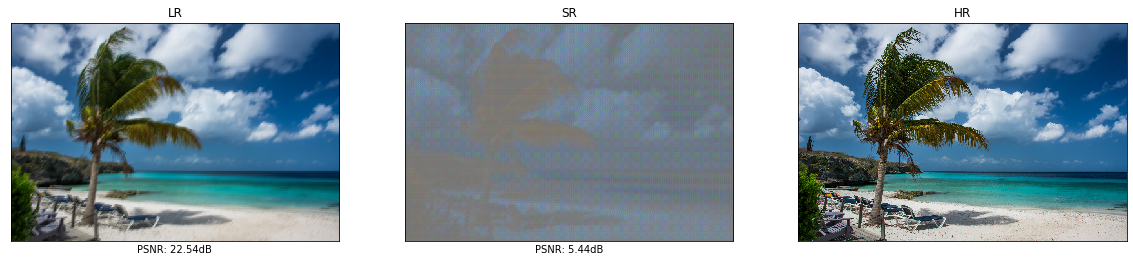

In [0]:
compare_images(gan_generator,'data/images/DIV2K_valid_LR_unknown/X4/0806x4.png','data/images/DIV2K_valid_HR/0806.png')

In [0]:
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

(411, 510, 3)
(1, 411, 510, 3)
(1644, 2040, 3)


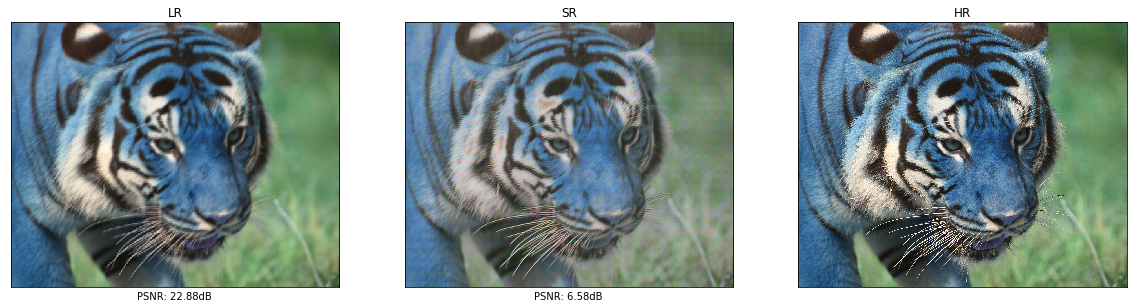

In [0]:
compare_images(gan_generator,'data/images/DIV2K_train_LR_unknown/X4/0010x4.png','data/images/DIV2K_train_HR/0010.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

(384, 510, 3)
(1, 384, 510, 3)
(1536, 2040, 3)


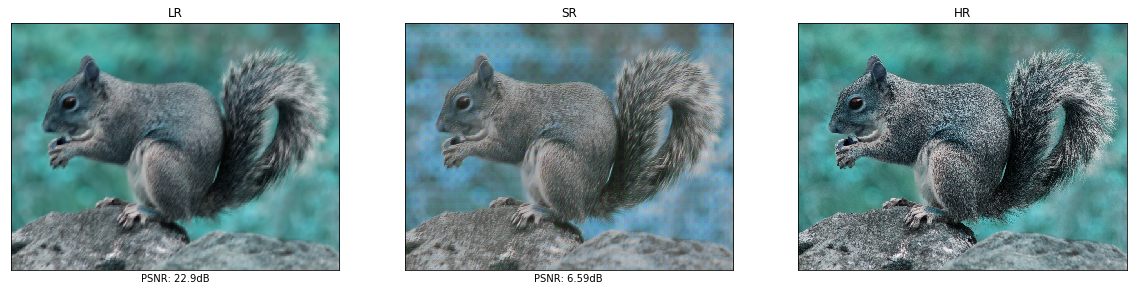

In [0]:
compare_images(gan_generator,'data/images/DIV2K_valid_LR_unknown/X4/0810x4.png','data/images/DIV2K_valid_HR/0810.png')

# Pre Output

In [0]:
pre_generator = generator()
pre_generator.load_weights('pre_generator.h5')

In [0]:
compare_images(pre_generator,'data/images/DIV2K_train_LR_unknown/X4/0010x4.png','data/images/DIV2K_train_HR/0010.png')

InvalidArgumentError: ignored

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

(339, 510, 3)
(1, 339, 510, 3)
(1356, 2040, 3)


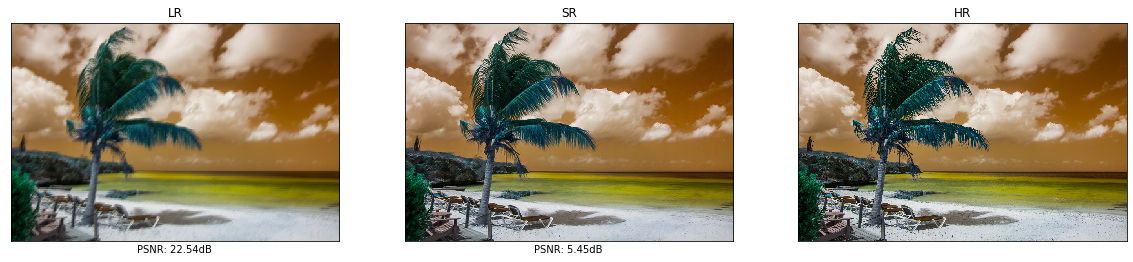

In [0]:
compare_images(pre_generator,'data/images/DIV2K_valid_LR_unknown/X4/0806x4.png','data/images/DIV2K_valid_HR/0806.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

In [0]:
!cp *.h5 gdrive/My\ Drive/SR/GAN